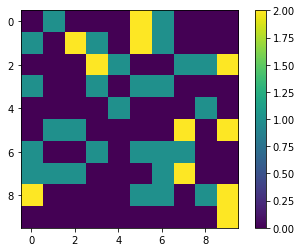

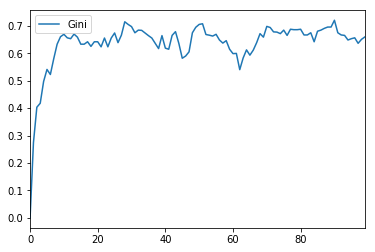

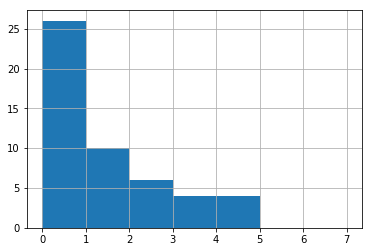

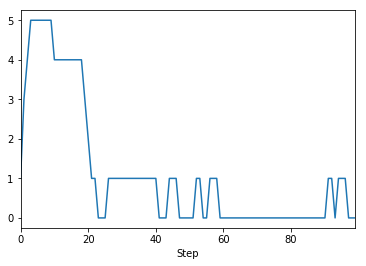

In [44]:
# model.py
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

class MoneyAgent(Agent):
    """An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
             
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1     
        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
    
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)
        
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})
        
    def step (self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()

# run.py
# all_wealth = []
# for j in range(100):
    # Run the model
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()
    
#     # Store the results
#     for agent in model.schedule.agents:
#         all_wealth.append(agent.wealth)
    
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

plt.show()

gini = model.datacollector.get_model_vars_dataframe()
gini.plot()
plt.show()

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))
plt.show()

one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()
plt.show()
# agent_wealth = [a.wealth for a in model.schedule.agents]
# plt.hist(all_wealth, bins=range(max(all_wealth)+1))
# plt.show()

In [ ]:
# Now for EV's
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


class EV_Model(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True) #toroidal (for now)
        self.schedule = RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            
    def step(self):
        self.schedule.step()
    